In [1]:
#new code cell below

In [114]:
pip install torch torchvision torchaudio 

Note: you may need to restart the kernel to use updated packages.


In [4]:
#new code cell below

In [1]:
import os

# Set up the base directory for dataset and weights
HOME = os.getcwd()
print("HOME:", HOME)

# Define dataset and weights directory
DATASET_PATH = os.path.join(HOME, "dataset")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
WEIGHTS_PATH = os.path.join(HOME, "weights")

# Create necessary directories if they don't exist
os.makedirs(WEIGHTS_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

print(f"✅ Dataset Path: {DATASET_PATH}")
print(f"✅ Images Path: {IMAGES_PATH}")
print(f"✅ Weights Path: {WEIGHTS_PATH}")

HOME: /Users/ma/Documents/samThesis/segment-anything/notebooks
✅ Dataset Path: /Users/ma/Documents/samThesis/segment-anything/notebooks/dataset
✅ Images Path: /Users/ma/Documents/samThesis/segment-anything/notebooks/dataset/images
✅ Weights Path: /Users/ma/Documents/samThesis/segment-anything/notebooks/weights


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
#!nvidia-smi

In [6]:
#new code cell below

In [8]:
import torch

print("PyTorch Version:", torch.__version__)
print("MPS Available:", torch.backends.mps.is_available())
print("MPS Device:", torch.device("mps") if torch.backends.mps.is_available() else "CPU Only")

PyTorch Version: 2.6.0
MPS Available: True
MPS Device: mps


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [11]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/ma/Documents/samThesis/segment-anything/notebooks


In [13]:
#new code cell below

In [15]:
import os

# Define the base dataset directory
HOME = os.getcwd()
DATASET_BASE_PATH = HOME  # Base directory

# Select resolution
IMAGE_SIZE = 16  # Change this for different resolutions (16, 28, 128, 256)
DATASET_FOLDER_NAME = f"shapes_dataset_{IMAGE_SIZE}x{IMAGE_SIZE}"

# Define dataset paths dynamically based on selected size
DATASET_PATH = os.path.join(DATASET_BASE_PATH, DATASET_FOLDER_NAME, "dataset")
IMAGES_DIRECTORY_PATH = os.path.join(DATASET_PATH, "images")
ANNOTATIONS_FILE_PATH = os.path.join(DATASET_PATH, "annotations", "shapes_coco.json")

# Print paths for verification
print(f"✅ Using Dataset: {DATASET_FOLDER_NAME}")
print(f"✅ Images Path: {IMAGES_DIRECTORY_PATH}")
print(f"✅ Annotations Path: {ANNOTATIONS_FILE_PATH}")

✅ Using Dataset: shapes_dataset_16x16
✅ Images Path: /Users/ma/Documents/samThesis/segment-anything/notebooks/shapes_dataset_16x16/dataset/images
✅ Annotations Path: /Users/ma/Documents/samThesis/segment-anything/notebooks/shapes_dataset_16x16/dataset/annotations/shapes_coco.json


In [17]:
#Define IoU & Dice Score Functions

In [19]:
import torch
import numpy as np

def compute_iou(pred_mask, gt_mask):
    """Computes Intersection over Union (IoU)"""
    intersection = torch.logical_and(pred_mask, gt_mask).sum().item()
    union = torch.logical_or(pred_mask, gt_mask).sum().item()
    return intersection / union if union > 0 else 0.0

def compute_dice(pred_mask, gt_mask):
    """Computes Dice Score (F1-Score for segmentation)"""
    intersection = torch.logical_and(pred_mask, gt_mask).sum().item()
    return (2 * intersection) / (pred_mask.sum().item() + gt_mask.sum().item()) if (pred_mask.sum().item() + gt_mask.sum().item()) > 0 else 0.0

print("✅ IoU & Dice functions are defined!")

✅ IoU & Dice functions are defined!


## Install Segment Anything Model (SAM) and other dependencies

### Download SAM weights

In [23]:
#!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

In [25]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

In [26]:
#new code cells below: Set Up the Environment to Use Local SAM

In [29]:
import sys
import os

# Define your SAM root directory
SAM_ROOT = "/Users/ma/Documents/samThesis/segment-anything"

# Add SAM to the Python path
sys.path.append(SAM_ROOT)

# Print to confirm
print("✅ SAM Local Path Added:", SAM_ROOT)

✅ SAM Local Path Added: /Users/ma/Documents/samThesis/segment-anything


In [31]:
#new code cells bellow: Verify & Set Up the Model Weights

In [33]:
import os

WEIGHTS_DIR = "/Users/ma/Documents/samThesis/segment-anything/weights"
os.makedirs(WEIGHTS_DIR, exist_ok=True)

print(f"✅ Weights directory ensured at: {WEIGHTS_DIR}")

✅ Weights directory ensured at: /Users/ma/Documents/samThesis/segment-anything/weights


In [35]:
import os

CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
WEIGHTS_DIR = "/Users/ma/Documents/samThesis/segment-anything/weights"
CHECKPOINT_PATH = os.path.join(WEIGHTS_DIR, "sam_vit_h_4b8939.pth")

# Create the weights directory if it doesn't exist
os.makedirs(WEIGHTS_DIR, exist_ok=True)

# Use curl instead of wget
if not os.path.isfile(CHECKPOINT_PATH):
    os.system(f"curl -o {CHECKPOINT_PATH} {CHECKPOINT_URL}")
    print(f"✅ Successfully downloaded SAM checkpoint to: {CHECKPOINT_PATH}")
else:
    print(f"✅ Checkpoint already exists at: {CHECKPOINT_PATH}")

✅ Checkpoint already exists at: /Users/ma/Documents/samThesis/segment-anything/weights/sam_vit_h_4b8939.pth


In [37]:
if os.path.exists(CHECKPOINT_PATH):
    print("✅ SAM checkpoint successfully downloaded!")
else:
    print("❌ ERROR: Checkpoint download failed.")

✅ SAM checkpoint successfully downloaded!


In [39]:
!pip install pennylane

In [41]:
from segment_anything import sam_model_registry, SamPredictor
import torch

# Use MPS for Mac M1/M2
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define the model type and local checkpoint path
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/Users/ma/Documents/samThesis/segment-anything/weights/sam_vit_h_4b8939.pth"

# Load the model from the local checkpoint
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

print(f"✅ Successfully loaded SAM model from {CHECKPOINT_PATH} on {DEVICE}")

✅ Successfully loaded SAM model from /Users/ma/Documents/samThesis/segment-anything/weights/sam_vit_h_4b8939.pth on mps


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [44]:
#!git clone https://github.com/cjpurackal/shapes.git

In [46]:
import os

REPO_PATH = "shapes"

# Check if the repo exists
if os.path.exists(REPO_PATH):
    print(f"✅ Repository found at: {os.path.abspath(REPO_PATH)}")
else:
    print(f"❌ ERROR: Repository not found at {REPO_PATH}")

✅ Repository found at: /Users/ma/Documents/samThesis/segment-anything/notebooks/shapes


In [48]:
cd shapes

/Users/ma/Documents/samThesis/segment-anything/notebooks/shapes


In [50]:
import os

# Define the resolutions
image_sizes = [16, 28, 128, 256]

# Loop through each resolution and run the command
for size in image_sizes:
    command = f"python run.py --save_dir ./shapes_dataset_{size}x{size} --image_size {size} {size} --num_images 100 --shapes circle rect --task_type segmentation"
    print(f"Running: {command}")  # Print to track progress
    os.system(command)  # Execute the command

print("✅ Dataset generation complete for all resolutions.")

Running: python run.py --save_dir ./shapes_dataset_16x16 --image_size 16 16 --num_images 100 --shapes circle rect --task_type segmentation


100%|██████████| 100/100 [00:01<00:00, 68.36it/s]


✅ Generated segmentation dataset in ./shapes_dataset_16x16 with COCO annotations
Running: python run.py --save_dir ./shapes_dataset_28x28 --image_size 28 28 --num_images 100 --shapes circle rect --task_type segmentation


100%|██████████| 100/100 [00:01<00:00, 85.09it/s]


✅ Generated segmentation dataset in ./shapes_dataset_28x28 with COCO annotations
Running: python run.py --save_dir ./shapes_dataset_128x128 --image_size 128 128 --num_images 100 --shapes circle rect --task_type segmentation


100%|██████████| 100/100 [00:01<00:00, 65.17it/s]


✅ Generated segmentation dataset in ./shapes_dataset_128x128 with COCO annotations
Running: python run.py --save_dir ./shapes_dataset_256x256 --image_size 256 256 --num_images 100 --shapes circle rect --task_type segmentation


100%|██████████| 100/100 [00:02<00:00, 36.42it/s]


✅ Generated segmentation dataset in ./shapes_dataset_256x256 with COCO annotations
✅ Dataset generation complete for all resolutions.


In [51]:
#Test

In [54]:
import os

# Define the dataset paths
datasets = ["16x16", "28x28", "128x128", "256x256"]

for size in datasets:
    dataset_path = f"./shapes_dataset_{size}/dataset"
    images_path = os.path.join(dataset_path, "images")
    annotations_path = os.path.join(dataset_path, "annotations/shapes_coco.json")

    print(f"\n📂 Checking {dataset_path} ...")
    print(f" - Images Directory Exists: {os.path.exists(images_path)}")
    print(f" - Annotations File Exists: {os.path.isfile(annotations_path)}")

    # List a few images
    if os.path.exists(images_path):
        images = os.listdir(images_path)[:5]  # Show first 5 images
        print(f" - Sample Images: {images}")

    # Check annotation file size
    if os.path.isfile(annotations_path):
        print(f" - Annotations File Size: {os.path.getsize(annotations_path)} bytes")


📂 Checking ./shapes_dataset_16x16/dataset ...
 - Images Directory Exists: True
 - Annotations File Exists: True
 - Sample Images: ['shapes_43.png', 'shapes_57.png', 'shapes_7.png', 'shapes_80.png', 'shapes_94.png']
 - Annotations File Size: 6983 bytes

📂 Checking ./shapes_dataset_28x28/dataset ...
 - Images Directory Exists: True
 - Annotations File Exists: True
 - Sample Images: ['shapes_43.png', 'shapes_57.png', 'shapes_7.png', 'shapes_80.png', 'shapes_94.png']
 - Annotations File Size: 6983 bytes

📂 Checking ./shapes_dataset_128x128/dataset ...
 - Images Directory Exists: True
 - Annotations File Exists: True
 - Sample Images: ['shapes_43.png', 'shapes_57.png', 'shapes_7.png', 'shapes_80.png', 'shapes_94.png']
 - Annotations File Size: 784897 bytes

📂 Checking ./shapes_dataset_256x256/dataset ...
 - Images Directory Exists: True
 - Annotations File Exists: True
 - Sample Images: ['shapes_43.png', 'shapes_57.png', 'shapes_7.png', 'shapes_80.png', 'shapes_94.png']
 - Annotations File

In [56]:
#Test

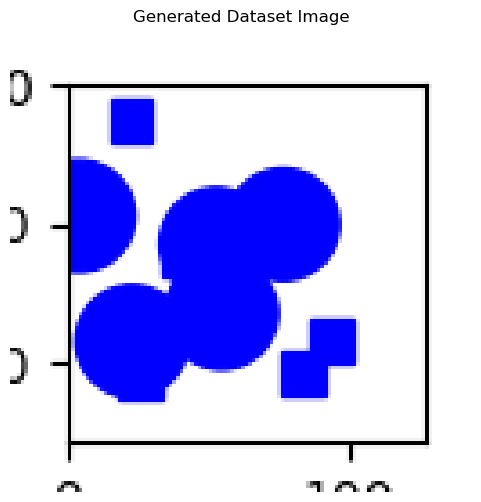

In [58]:
import matplotlib.pyplot as plt
import cv2

# Load an example image from the generated dataset
image_path = "./shapes_dataset_128x128/dataset/images/shapes_10.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Generated Dataset Image")
plt.show()

In [60]:
#Test

In [62]:
import json

# Select the dataset size to check
dataset_size = "128x128"  # Change to 16x16, 28x28, or 256x256

# Define annotation file path
annotation_file = f"./shapes_dataset_{dataset_size}/dataset/annotations/shapes_coco.json"

# Load and inspect annotations
with open(annotation_file, "r") as f:
    coco_data = json.load(f)

print(f"\n✅ Loaded {annotation_file}")
print(f" - Total Images: {len(coco_data['images'])}")
print(f" - Total Annotations: {len(coco_data['annotations'])}")

# Show first 2 annotations for verification
print("\n🔍 Sample Annotation:")
print(json.dumps(coco_data["annotations"][:2], indent=4))


✅ Loaded ./shapes_dataset_128x128/dataset/annotations/shapes_coco.json
 - Total Images: 100
 - Total Annotations: 1552

🔍 Sample Annotation:
[
    {
        "id": 1,
        "image_id": 0,
        "category_id": 2,
        "segmentation": [
            [
                16,
                9,
                31,
                9,
                31,
                24,
                16,
                24
            ]
        ],
        "area": 400,
        "bbox": [
            16,
            9,
            20,
            20
        ],
        "iscrowd": 0
    },
    {
        "id": 2,
        "image_id": 0,
        "category_id": 1,
        "segmentation": [
            [
                42.0,
                10.0,
                40.91634483401269,
                16.49398938409367,
                37.78281018792787,
                22.284254253793357,
                32.93896316244854,
                26.74332956525057,
                26.909709742815984,
                29.

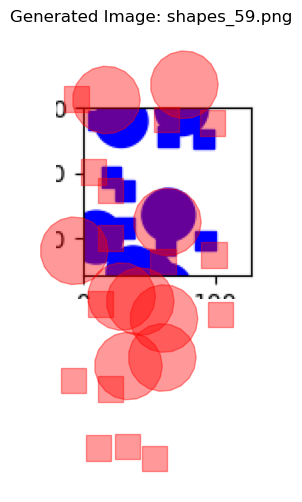

In [64]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import random
import os

# Choose dataset size
dataset_size = "128x128"  # Change this to 16x16, 28x28, or 256x256

# Define the paths
images_dir = f"./shapes_dataset_{dataset_size}/dataset/images"
annotations_file = f"./shapes_dataset_{dataset_size}/dataset/annotations/shapes_coco.json"

# Load annotation data
with open(annotations_file, "r") as f:
    coco_data = json.load(f)

# Pick a random image
image_info = random.choice(coco_data["images"])
image_filename = image_info["file_name"]
image_path = os.path.join(images_dir, image_filename)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get annotations for the selected image
image_annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_info["id"]]

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Generated Image: {image_filename}")

# Overlay segmentation masks
for ann in image_annotations:
    segmentation = np.array(ann["segmentation"][0]).reshape(-1, 2)  # Convert segmentation to (x, y) pairs
    plt.fill(segmentation[:, 0], segmentation[:, 1], color="red", alpha=0.4)  # Red mask overlay

plt.show()

## Load Model

In [67]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [69]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [71]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [74]:
import os
import random

# Correct dataset path
dataset_size = "128x128"
IMAGES_DIRECTORY_PATH = f"/Users/ma/Documents/samThesis/segment-anything/notebooks/shapes/shapes_dataset_{dataset_size}/dataset/images"

# Ensure directory exists before selecting an image
if os.path.exists(IMAGES_DIRECTORY_PATH) and os.listdir(IMAGES_DIRECTORY_PATH):
    IMAGE_NAME = random.choice(os.listdir(IMAGES_DIRECTORY_PATH))
    IMAGE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, IMAGE_NAME)
    print(f"✅ Using Image: {IMAGE_PATH}")
else:
    print(f"❌ ERROR: No images found in {IMAGES_DIRECTORY_PATH}")

✅ Using Image: /Users/ma/Documents/samThesis/segment-anything/notebooks/shapes/shapes_dataset_128x128/dataset/images/shapes_42.png


### Generate masks with SAM

#### import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Ground Truth Mask
plt.subplot(1, 2, 1)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

# Plot Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show() 

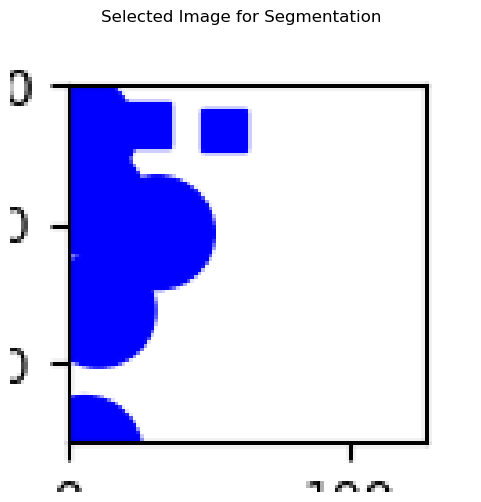

✅ Total detected masks: 21
🔹 IoU: 0.0015, Dice Score: 0.0029


In [77]:
import cv2
import supervision as sv
import matplotlib.pyplot as plt

# Load the selected image
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Display the selected image before segmentation
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title("Selected Image for Segmentation")
plt.axis("off")
plt.show()

# Generate segmentation masks
sam_result = mask_generator.generate(image_rgb)


print(f"✅ Total detected masks: {len(sam_result)}")

# Convert SAM output to binary mask
predicted_mask = sam_result[0]['segmentation']  # Assuming first mask
predicted_mask = torch.tensor(predicted_mask).bool()

# Load the ground truth mask from COCO annotations
gt_mask = None
for ann in coco_data["annotations"]:
    if ann["image_id"] == image_info["id"]:
        gt_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        segmentation = np.array(ann["segmentation"][0]).reshape(-1, 2)
        cv2.fillPoly(gt_mask, [segmentation.astype(np.int32)], color=1)
        gt_mask = torch.tensor(gt_mask).bool()
        break

# Ensure ground truth mask exists
if gt_mask is not None:
    # Compute IoU & Dice Score
    iou_score = compute_iou(predicted_mask, gt_mask)
    dice_score = compute_dice(predicted_mask, gt_mask)

    # Print the results
    print(f"🔹 IoU: {iou_score:.4f}, Dice Score: {dice_score:.4f}")
else:
    print("❌ No ground truth mask found for this image.")

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [80]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

✅ Total detected masks: 21


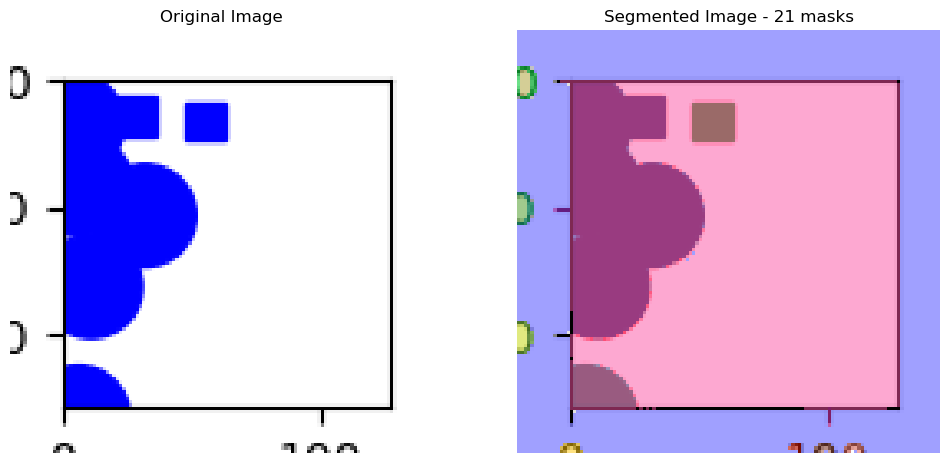

In [84]:
import supervision as sv
import matplotlib.pyplot as plt

print(f"✅ Total detected masks: {len(sam_result)}")

# Create a mask annotator
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert SAM output to supervision-compatible format
detections = sv.Detections.from_sam(sam_result=sam_result)  # Use all masks, no filtering

# Annotate the image with segmentation masks
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Display original and segmented images side by side
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(annotated_image)
plt.title(f"Segmented Image - {len(sam_result)} masks")
plt.axis("off")

plt.show()


### Interaction with segmentation results

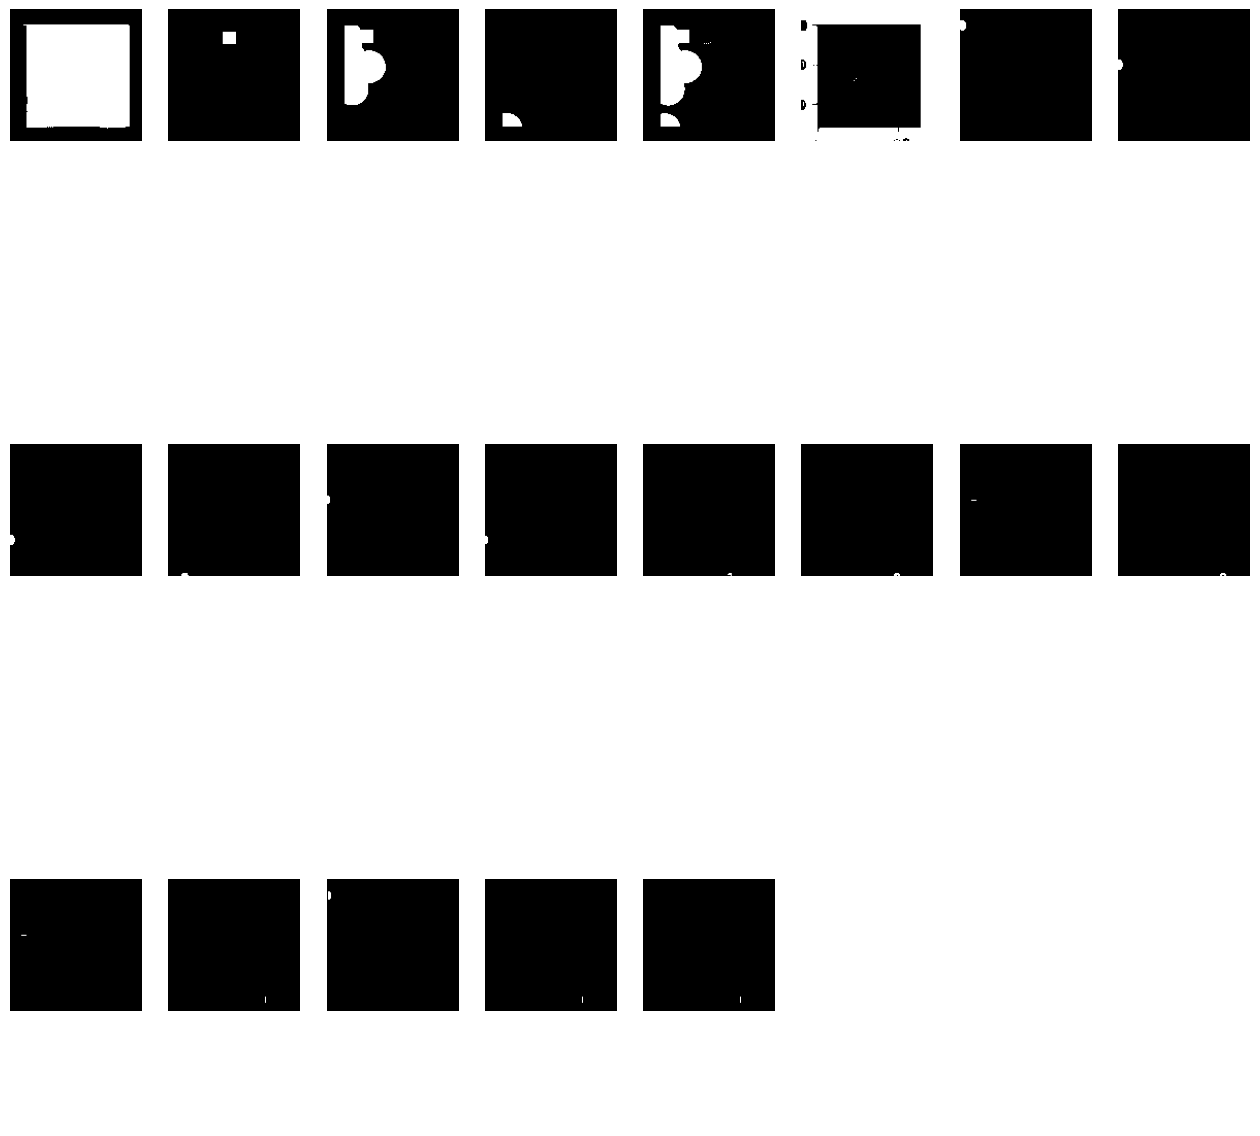

In [87]:
# Show all masks without filtering
masks = [mask['segmentation'] for mask in sam_result]

# Calculate grid size dynamically
num_masks = len(masks)
grid_cols = min(8, num_masks)  # Limit columns to a max of 8
grid_rows = (num_masks // grid_cols) + (num_masks % grid_cols > 0)  # Ensure all images fit

# Display masks in a properly sized grid
sv.plot_images_grid(
    images=masks,
    grid_size=(grid_rows, grid_cols),  # Auto-adjusted grid size
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [90]:
mask_predictor = SamPredictor(sam)

In [92]:
import os
import random

# Verify the images directory exists
if not os.path.exists(IMAGES_DIRECTORY_PATH):
    print(f"❌ ERROR: Images directory does not exist: {IMAGES_DIRECTORY_PATH}")
else:
    # Load image filenames
    IMAGES = os.listdir(IMAGES_DIRECTORY_PATH)

    if len(IMAGES) == 0:
        print("❌ ERROR: No images found in the dataset folder.")
    else:
        # Pick a random image
        IMAGE_NAME = random.choice(IMAGES)
        IMAGE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, IMAGE_NAME)

        print(f"✅ Using Image: {IMAGE_PATH}")

✅ Using Image: /Users/ma/Documents/samThesis/segment-anything/notebooks/shapes/shapes_dataset_128x128/dataset/images/shapes_66.png


### Draw Box



In [95]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [98]:
import os

# Automatically detect the environment
try:
    import google.colab
    IS_COLAB = True
    from google.colab import output
    output.enable_custom_widget_manager()
    print("✅ Running in Google Colab")
except ImportError:
    IS_COLAB = False
    print("✅ Running in Local Jupyter Notebook")

✅ Running in Local Jupyter Notebook


In [100]:
!pip install jupyter_bbox_widget

In [101]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [104]:
widget.bboxes

[]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [108]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [110]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

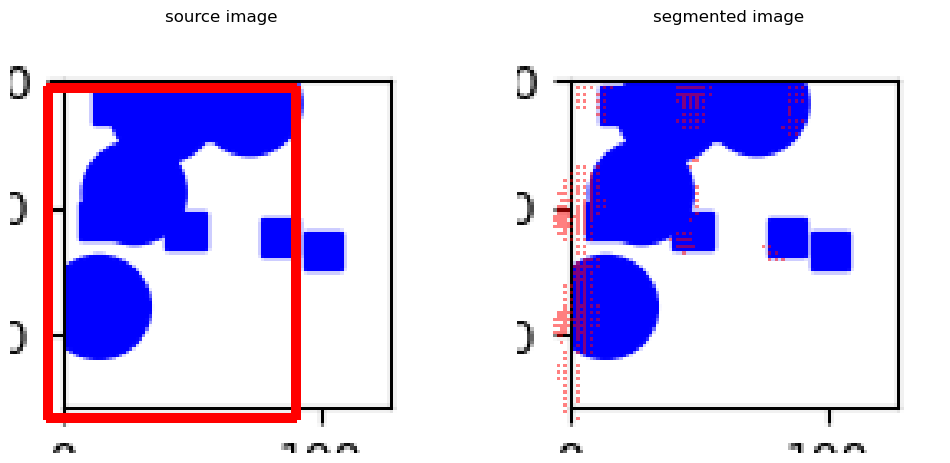

In [113]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

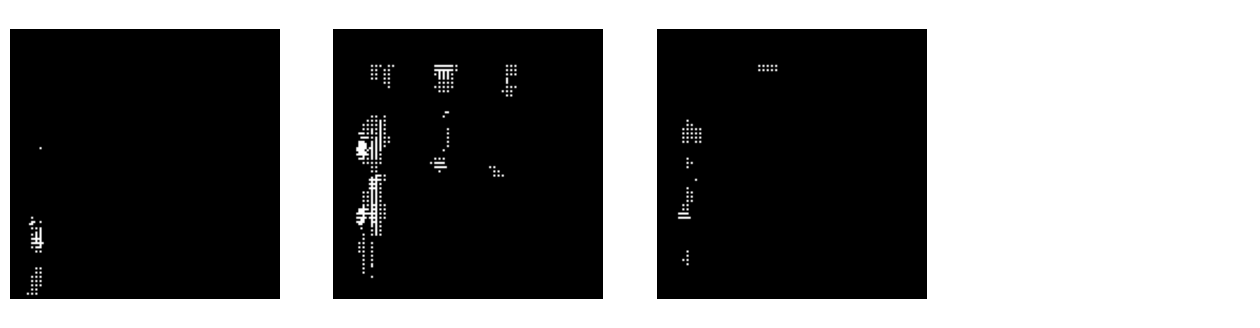

In [116]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.